# Baseline training

This script trains a baseline model based on the generated data from script 1.

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from vigor.agent import RecommendationAgent

In [3]:
agent = RecommendationAgent(n_statistics=7, alpha=0.1, epsilon=0.3)

agent.add_domain('general')

agent.add_visualization('nodelink topology driven')
agent.add_visualization('nodelink attribute driven faceting')
agent.add_visualization('nodelink attribute driven positioning')
agent.add_visualization('adjacency matrix')
agent.add_visualization('quilts')
agent.add_visualization('biofabric')
agent.add_visualization('treemap')
agent.add_visualization('sunburst')

In [4]:
with open('../data/interactions.json', 'r') as file:
    interactions = json.load(file)

In [5]:
n = 100
rewards = []
average_rewards = []
sample_intervals = []

for i, sample in enumerate(interactions[:5000]):
    domain = sample['domain']
    statistics = sample['statistics']
    ranked_visualizations = sample['sorted_visualizations']

    state_id = agent.state_id(statistics)
    action = agent.recommend_visualization(domain, state_id)
    
    prediction = agent.visualizations[action]
    rank = ranked_visualizations.index(prediction)
    max_rank = len(ranked_visualizations) - 1
    reward = round(5 - 10 * rank / max_rank, 2) if max_rank > 0 else 5

    agent.update_q_value(domain, state_id, action, reward=reward)

    rewards.append(reward)

    if (i + 1) % n == 0:
        avg_reward = np.mean(rewards[-n:])
        average_rewards.append(avg_reward)
        sample_intervals.append(i + 1)
        print(f'Round: {i+1}, Average Reward: {avg_reward:.2f}')

Round: 100, Average Reward: 1.67
Round: 200, Average Reward: 2.07
Round: 300, Average Reward: 2.28
Round: 400, Average Reward: 2.96
Round: 500, Average Reward: 2.61
Round: 600, Average Reward: 2.70
Round: 700, Average Reward: 2.57
Round: 800, Average Reward: 2.69
Round: 900, Average Reward: 2.36
Round: 1000, Average Reward: 2.98
Round: 1100, Average Reward: 2.73
Round: 1200, Average Reward: 2.80
Round: 1300, Average Reward: 2.94
Round: 1400, Average Reward: 2.43
Round: 1500, Average Reward: 2.70
Round: 1600, Average Reward: 3.04
Round: 1700, Average Reward: 3.44
Round: 1800, Average Reward: 3.20
Round: 1900, Average Reward: 2.96
Round: 2000, Average Reward: 3.13
Round: 2100, Average Reward: 2.73
Round: 2200, Average Reward: 3.13
Round: 2300, Average Reward: 3.20
Round: 2400, Average Reward: 2.74
Round: 2500, Average Reward: 3.64
Round: 2600, Average Reward: 2.61
Round: 2700, Average Reward: 2.76
Round: 2800, Average Reward: 3.21
Round: 2900, Average Reward: 3.16
Round: 3000, Average Re

In [6]:
# Save such I can get results for multiple parameter sets in my plots
data = {
    'sample_intervals': sample_intervals,
    'average_rewards': average_rewards
}

with open(f'../data/analysis/result_{agent.alpha}_{agent.epsilon}.json', 'w') as f:
    json.dump(data, f)

## Decision boundaries

In [30]:
state_ids = []
labels = []

for key, value in agent.scores['general'].items():
    state_id = list(map(float, key.split(',')))
    label = agent.visualizations[np.argmax(value)]

    state_ids.append(state_id)
    labels.append(label)


state_ids = np.array(state_ids)
labels = np.array(labels)

pca = PCA(n_components=2)
state_ids_2d = pca.fit_transform(state_ids)

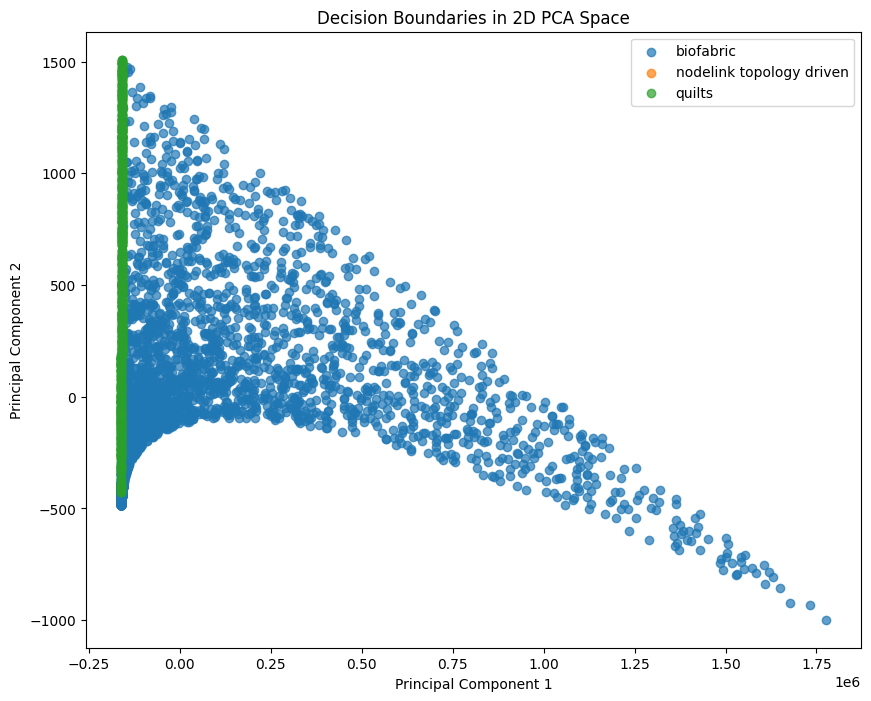

In [31]:
plt.figure(figsize=(10, 8))

unique_labels = np.unique(labels)
for label in unique_labels:
    mask = (labels == label)
    plt.scatter(state_ids_2d[mask, 0], state_ids_2d[mask, 1], label=label, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundaries in 2D PCA Space')
plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

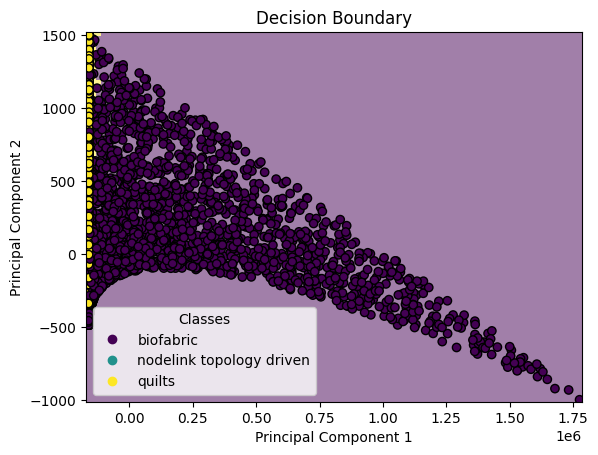

In [32]:
# Code from: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)

plt.figure(figsize=(10, 8))

weights = "distance"
clf.set_params(knn__weights=weights).fit(state_ids_2d, numeric_labels)
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    state_ids_2d,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="Principal Component 1",
    ylabel="Principal Component 2",
    shading="auto",
    alpha=0.5,
)
scatter = disp.ax_.scatter(state_ids_2d[:, 0], state_ids_2d[:, 1], c=numeric_labels, edgecolors="k", cmap='viridis')
unique_labels = label_encoder.classes_
disp.ax_.legend(
    scatter.legend_elements()[0],
    unique_labels,
    loc="lower left",
    title="Classes",
)
_ = disp.ax_.set_title(
    f"Decision Boundary"
)

plt.show()

# Feature importances

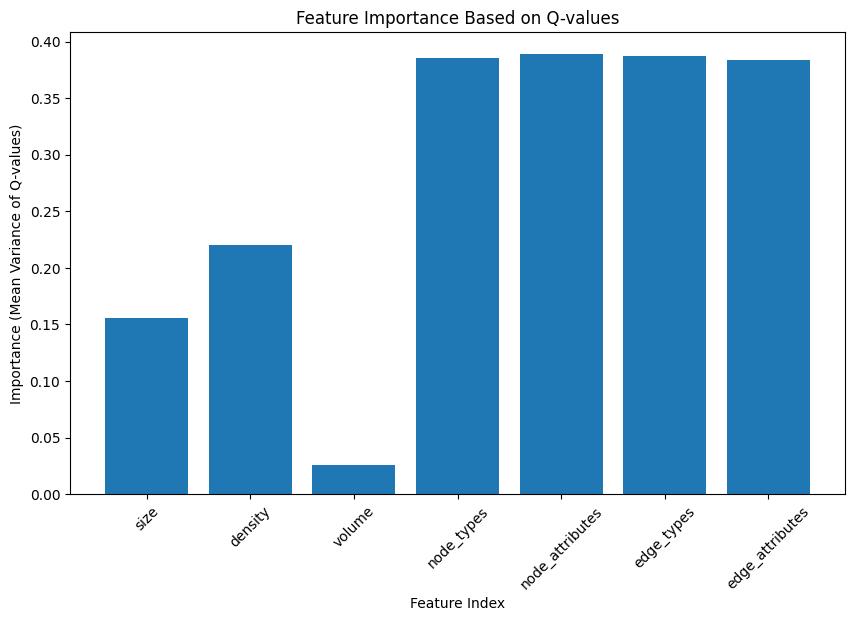

In [33]:
feature_names = [
    "size", "density", "volume", "node_types", "node_attributes", "edge_types", "edge_attributes"
]

state_ids = []
q_values = []

for key, value in agent.scores['general'].items():
    state_id = list(map(float, key.split(',')))
    q_value = value

    state_ids.append(state_id)
    q_values.append(q_value)

state_ids = np.array(state_ids)
q_values = np.array(q_values)
n_features = state_ids.shape[1]
feature_importances = np.zeros(n_features)

for i in range(n_features):
    unique_values = np.unique(state_ids[:, i])
    feature_q_variance = []

    for val in unique_values:
        indices = np.where(state_ids[:, i] == val)
        q_subset = q_values[indices]
        q_variance = np.var(q_subset, axis=0).mean()
        feature_q_variance.append(q_variance)

    feature_importances[i] = np.mean(feature_q_variance)

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance (Mean Variance of Q-values)')
plt.title('Feature Importance Based on Q-values')
plt.xticks(rotation=45)
plt.show()